In [81]:
# Import AWS and Sagemaker SDKs and get files access
import boto3
import io
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
bucket ='sagemaker-data-energy-demand'

In [136]:
role = get_execution_role()

In [67]:
import sys
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import json
import time

In [35]:
# Import data 

CITY = 'LosAngeles'
train_key = 'dataframes/%s/train/data_train.csv' % CITY
validation_key = 'dataframes/%s/test/data_validation.csv' % CITY

train_location = 's3://{}/{}'.format(bucket, train_key)
validation_location = 's3://{}/{}'.format(bucket, validation_key)

df = pd.read_csv(train_location, index_col='datetime', parse_dates=True)
df_test = pd.read_csv(validation_location, index_col='datetime', parse_dates=True)

In [39]:
dt_predict_max_date = str(df_test.tail(1).index.values[0]).replace('T', ' ')        
datetime_predict_max = datetime.strptime(dt_predict_max_date[:-10], '%Y-%m-%d %H:%M:%S')

dt_dataset_start = str(df.head(1).index.values[0]).replace('T', ' ')        
datetime_dt_dataset_start = datetime.strptime(dt_dataset_start[:-10], '%Y-%m-%d %H:%M:%S')


split_validation_date = datetime_predict_max - timedelta(days=15)
split_validation_date_str = str(split_validation_date)

In [51]:
# Timeseries consists hourly Data and we need to predict hourly rental count
freq='H' 

# how far in the future predictions can be made
# 15 days worth of hourly forecast 
prediction_length = 15 * 24 

# AWS recommends setting context same as prediction length as a starting point
# This controls how far in the past the network can see
context_length = prediction_length

dt_predict_max = pd.Timestamp(datetime_predict_max, freq=freq)

dt_dataset_start_time = pd.Timestamp(datetime_dt_dataset_start, freq=freq)
dt_dataset_end_time = pd.Timestamp(split_validation_date, freq=freq)

# use for model training
# Start time is the first row provided by dataset
# Training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing
dt_train_range = (dt_dataset_start_time,
                  dt_dataset_end_time - timedelta(hours=15*24) )

# Use entire data for testing
# We can compare predicted values vs actual (i.e. last 12 days is withheld for testing and model hasn't seen that data)
dt_test_range = (dt_dataset_start_time, 
                 dt_dataset_end_time) 


In [52]:
dynamic_features = [
 'dailycoolingdegreedays(t-1)',
 'dailyheatingdegreedays(t-1)',
 'hourlydewpointtemperature(t-1)',
 'hourlydrybulbtemperature(t-1)',
 'hourlyprecipitation(t-1)',
 'hourlyrelativehumidity(t-1)',
 'hourlyvisibility(t-1)',
 'hourlywindspeed(t-1)',
 'hourlycoolingdegrees(t-1)',
 'hourlyheatingdegrees(t-1)',
 'hourlyskyconditions_BKN(t-1)',
 'hourlyskyconditions_FEW(t-1)',
 'hourlyskyconditions_SCT(t-1)',
 'hour(t-1)',
 'hour(t)',
 'dayofweek(t)',
 'quarter(t)',
 'month(t)',
 'year(t)',
 'dayofyear(t)',
 'dayofmonth(t)',
 'weekofyear(t)',
 'isbusinessday(t)',
 'isholiday(t)',
 'daylight(t)']
target_values = ['demand(t)']

In [53]:
# Let's see if there are gaps in timesteps
def is_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return not dt_range.equals(df[start:end].index)

def get_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return dt_range.difference(df[start:end].index)    

# List timeseries with only NaNs
# They can be removed
def timeseries_with_only_nans(df):
    l = []
    for col in df.columns:
        if pd.isna(df[col].min()):
            #print (col)
            l.append(col)
    return l

In [54]:
get_missing_steps(df,df.index.min(),df.index.max(),'H')

DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='H')

In [55]:
df = df.resample('1h').mean()

In [56]:
fill_dict = {'median': ['dailyheatingdegreedays', 'hourlyaltimetersetting', 'hourlydrybulbtemperature', 'hourlyprecipitation', 'hourlysealevelpressure', 'hourlystationpressure', 'hourlywetbulbtempf', 'dailycoolingdegreedays', 'hourlyvisibility', 'hourlywindspeed', 'hourlycoolingdegrees', 'hourlyheatingdegrees'], 'ffill': ['demand', 'hourlydewpointtemperature', 'hourlyrelativehumidity']}

# fill weather data NaNs
for col in df.columns:
    if col == 'hourlyskyconditions':
        df[col].fillna(df[col].value_counts().index[0], inplace=True) 
    elif col in fill_dict['median']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].ffill(), inplace=True)

In [57]:
df.isnull().sum()

demand(t)                         0
dailycoolingdegreedays(t-1)       0
dailyheatingdegreedays(t-1)       0
hourlydewpointtemperature(t-1)    0
hourlydrybulbtemperature(t-1)     0
hourlyprecipitation(t-1)          0
hourlyrelativehumidity(t-1)       0
hourlyvisibility(t-1)             0
hourlywindspeed(t-1)              0
hourlycoolingdegrees(t-1)         0
hourlyheatingdegrees(t-1)         0
hourlyskyconditions_BKN(t-1)      0
hourlyskyconditions_FEW(t-1)      0
hourlyskyconditions_SCT(t-1)      0
hour(t-1)                         0
hour(t)                           0
dayofweek(t)                      0
quarter(t)                        0
month(t)                          0
year(t)                           0
dayofyear(t)                      0
dayofmonth(t)                     0
weekofyear(t)                     0
isbusinessday(t)                  0
isholiday(t)                      0
daylight(t)                       0
dtype: int64

In [58]:
df_dynamic_feat = df[dynamic_features]


time_series_test = []
time_series_training = []

for t in target_values:
    time_series_test.append(df[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df[dt_train_range[0]:dt_train_range[1]][t])

In [61]:
# Dynamic features are the same for count, registered, casual
dynamic_features_test = df_dynamic_feat [dt_test_range[0]:dt_test_range[1]]
dynamic_features_training = df_dynamic_feat[dt_train_range[0]:dt_train_range[1]]

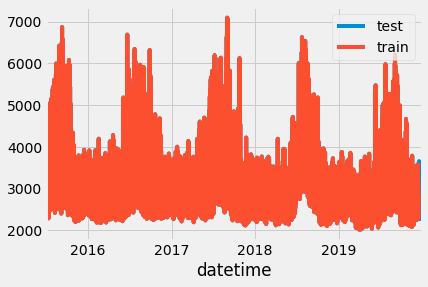

In [64]:
time_series_test[0].plot(label='test')
time_series_training[0].plot(label='train')

plt.legend()
plt.show()

In [101]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0])[:-6], "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))   

In [102]:
series_to_jsonline(time_series_training[0][:5], dynamic_feat=dynamic_features_training[:5])

'{"start": "2015-07-01 09:00:00", "target": [3045.0, 2892.0, 2787.0, 2790.0, 2899.0], "dynamic_feat": [[11.0, 11.0, 11.0, 11.0, 11.0], [0.0, 0.0, 0.0, 0.0, 0.0], [63.0, 64.0, 63.0, 61.0, 61.0], [74.0, 77.0, 82.0, 84.0, 81.0], [0.0, 0.0, 0.0, 0.0, 0.0], [69.0, 64.0, 53.0, 46.0, 51.0], [10.0, 10.0, 10.0, 10.0, 10.0], [0.0, 0.0, 0.0, 3.0, 3.0], [9.0, 12.0, 17.0, 19.0, 16.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [8.0, 9.0, 10.0, 11.0, 12.0], [9.0, 10.0, 11.0, 12.0, 13.0], [2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3.0, 3.0, 3.0, 3.0], [7.0, 7.0, 7.0, 7.0, 7.0], [2015.0, 2015.0, 2015.0, 2015.0, 2015.0], [182.0, 182.0, 182.0, 182.0, 182.0], [1.0, 1.0, 1.0, 1.0, 1.0], [27.0, 27.0, 27.0, 27.0, 27.0], [1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0]]}'

In [103]:
encoding = "utf-8"
with open("train_dynamic_feat.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts,dynamic_feat=dynamic_features_training).encode(encoding))
        fp.write('\n'.encode(encoding))

In [104]:
with open("test_dynamic_feat.json", 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts,dynamic_feat=dynamic_features_test).encode(encoding))
        fp.write('\n'.encode(encoding))

In [105]:
df.to_csv('all_data_dynamic_feat.csv',index=True,index_label='datetime')

In [106]:
for ts in time_series_test:
    print (len(ts),ts.name)

39447 demand(t)


In [107]:
for ts in time_series_training:
    print (len(ts),ts.name)

39087 demand(t)


In [108]:
with_categories = False
# Set a good base job name when building different models
# It will help in identifying trained models and endpoints
base_job_name = 'deepar-energy-demand-dynamic-features'

In [109]:
prefix = 'deepar/energy-demand'

# This structure allows multiple training and test files for model development and testing
s3_data_path = "{}/{}/data_dynamic".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [110]:
s3_data_path,s3_output_path

('sagemaker-data-energy-demand/deepar/energy-demand/data_dynamic',
 'sagemaker-data-energy-demand/deepar/energy-demand/output')

In [111]:
# File name is referred as key name in S3
# Files stored in S3 are automatically replicated across
# three different availability zones in the region where the bucket was created.
# http://boto3.readthedocs.io/en/latest/guide/s3.html
def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [112]:
# Upload one or more training files and test files to S3
write_to_s3('train_dynamic_feat.json',bucket,'deepar/energy-demand/data_dynamic/train/train_dynamic_feat.json')
write_to_s3('test_dynamic_feat.json',bucket,'deepar/energy-demand/data_dynamic/test/test_dynamic_feat.json')

In [113]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [114]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.4xlarge',
    base_job_name=base_job_name,
    output_path="s3://" + s3_output_path
)

In [115]:
freq, context_length, prediction_length

('H', 360, 360)

In [116]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "cardinality" : "auto" if with_categories else ''
}

In [117]:
estimator.set_hyperparameters(**hyperparameters)

In [118]:
# Here, we are simply referring to train path and test path
# You can have multiple files in each path
# SageMaker will use all the files
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

In [119]:
# This step takes around 35 minutes to train the model with m4.xlarge instance
estimator.fit(inputs=data_channels)

2020-01-18 01:03:32 Starting - Starting the training job...
2020-01-18 01:03:33 Starting - Launching requested ML instances......
2020-01-18 01:04:36 Starting - Preparing the instances for training...
2020-01-18 01:05:15 Downloading - Downloading input data...
2020-01-18 01:05:52 Training - Training image download completed. Training in progress.Arguments: train
[01/18/2020 01:05:54 INFO 139837668939584] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''

In [121]:
job_name = estimator.latest_training_job.name

In [141]:
instance_type='ml.t2.medium'

In [143]:
# Create an endpoint for real-time predictions
endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'ml.m4.xlarge for endpoint usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

In [125]:
?E2ed!r\75#<SD\B

'arn:aws:iam::758438347448:role/service-role/AmazonSageMaker-ExecutionRole-20200112T192035'

In [ ]:
print ('endpoint name: {0}'.format(endpoint_name))

In [138]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k], 
                                   cat[k] if cat else None,
                                   dynamic_feat) 
                     for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [139]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

NameError: name 'endpoint_name' is not defined